 **Práctica de Deep Learning - 3 de Julio de 2024**

In [28]:
# Install Essential Libraries
import locale
locale.getpreferredencoding = lambda: "UTF-8"
# Import Essential Libraries
import os
import random
import pandas as pd
from PIL import Image
import cv2
from ultralytics import YOLO
from IPython.display import Video
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import pathlib
import glob
import torch
from tqdm.notebook import trange, tqdm
import warnings
warnings.filterwarnings('ignore')
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.3.0+cu121 (Tesla T4)


In [29]:
!pip install ultralytics


In [30]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jun 17 16:25:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0              35W /  70W |    699MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


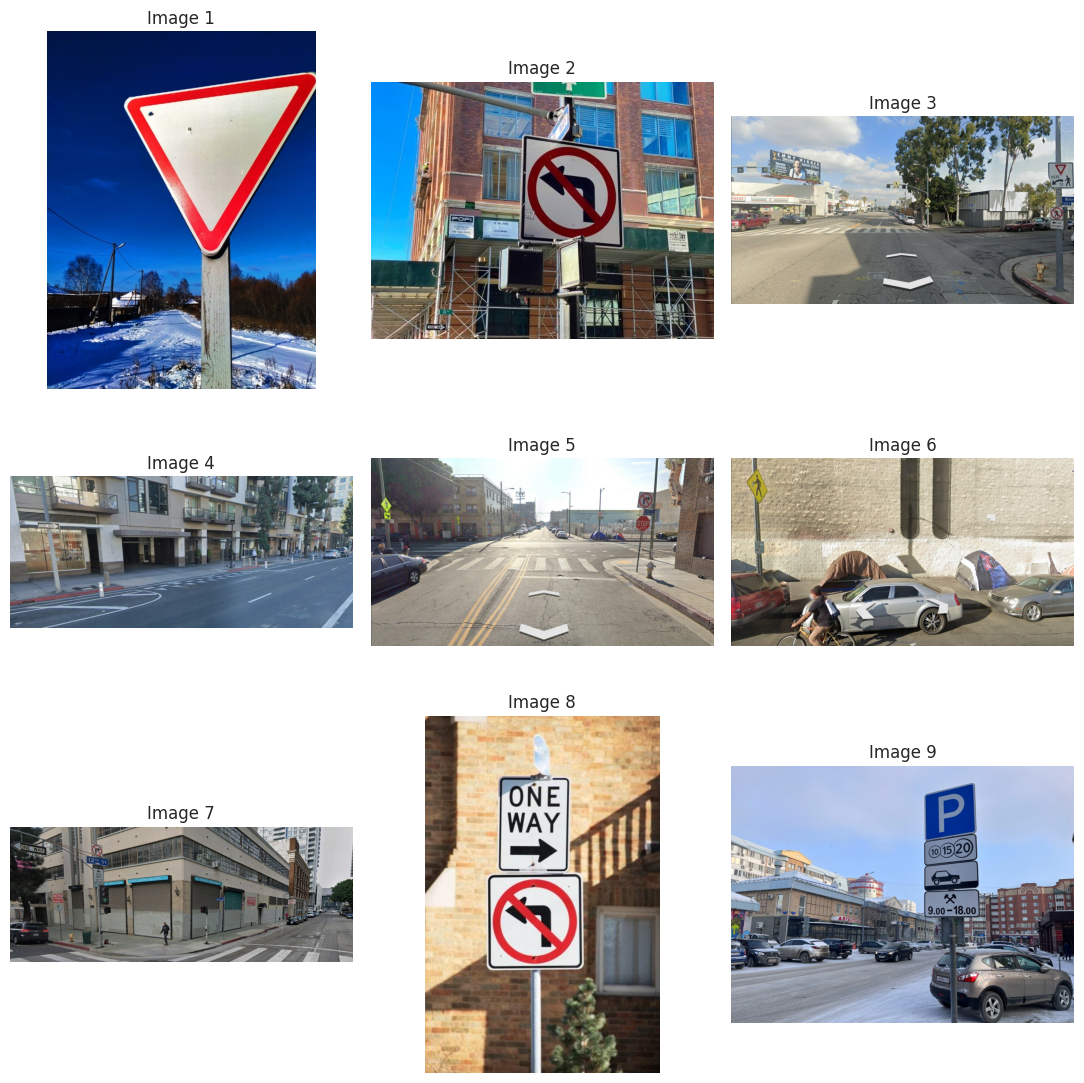

In [ ]:
Image_dir = '/content/drive/MyDrive/dataset_vlc/images/train'

num_samples = 9
image_files = os.listdir(Image_dir)

# Randomly select num_samples images
rand_images = random.sample(image_files, num_samples)

fig, axes = plt.subplots(3, 3, figsize=(11, 11))

for i in range(num_samples):
    image = rand_images[i]
    ax = axes[i // 3, i % 3]
    ax.imshow(plt.imread(os.path.join(Image_dir, image)))
    ax.set_title(f'Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Get the size of the image
image = cv2.imread("/content/drive/MyDrive/dataset_vlc/images/train/0.jpg")
h, w, c = image.shape
print(f"The image has dimensions {w}x{h} and {c} channels.")

The image has dimensions 750x563 and 3 channels.


In [ ]:
# # Use a pretrained YOLOv8n model
# model = YOLO("yolov8n.pt")

# # Use the model to detect object
# image = "/content/drive/MyDrive/dataset_vlc/images/train/0.jpg"
# result_predict = model.predict(source = image, imgsz=(416))

# # show results
# plot = result_predict[0].plot()
# plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
# display(Image.fromarray(plot))

In [ ]:
import os
import yaml
import random
from collections import defaultdict
from PIL import Image
import matplotlib.pyplot as plt

# Especifica los IDs de las clases que quieres mantener
desired_classes = [0, 1, 2, 3, 4]  # Cambia estos valores según las clases que quieras

def filter_labels(labels_path, desired_classes):
    # Filtrar las etiquetas para mantener sólo las clases deseadas
    for root, dirs, files in os.walk(labels_path):
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                filtered_lines = []
                with open(file_path, 'r') as f:
                    for line in f.readlines():
                        class_id = int(line.split()[0])
                        if class_id in desired_classes:
                            filtered_lines.append(line)
                # Sobrescribir el archivo de etiquetas con las líneas filtradas
                with open(file_path, 'w') as f:
                    f.writelines(filtered_lines)

def get_unique_class_ids(labels_path):
    class_ids = set()
    for root, dirs, files in os.walk(labels_path):
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as f:
                    for line in f.readlines():
                        class_id = int(line.split()[0])
                        class_ids.add(class_id)
    return sorted(class_ids)

def create_class_name_mapping(labels_path, desired_classes):
    class_names = {}
    for root, dirs, files in os.walk(labels_path):
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as f:
                    for line in f.readlines():
                        class_id = int(line.split()[0])
                        if class_id in desired_classes and class_id not in class_names:
                            class_names[class_id] = f'class_{class_id}'
    return class_names

def get_examples_by_class(labels_path, desired_classes, num_examples=5):
    examples = defaultdict(list)
    for root, dirs, files in os.walk(labels_path):
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                image_path = file_path.replace('labels', 'images').replace('.txt', '.jpg')
                with open(file_path, 'r') as f:
                    for line in f.readlines():
                        class_id = int(line.split()[0])
                        if class_id in desired_classes:
                            examples[class_id].append(image_path)
                            break  # We only need one instance of each class per image
    # Select num_examples from each class
    for class_id in examples:
        examples[class_id] = random.sample(examples[class_id], min(num_examples, len(examples[class_id])))
    return examples

def show_examples(examples, class_name_mapping):
    for class_id, image_paths in examples.items():
        fig, axes = plt.subplots(1, len(image_paths), figsize=(20, 5))
        fig.suptitle(f"Examples of {class_name_mapping[class_id]}")
        for ax, img_path in zip(axes, image_paths):
            image = Image.open(img_path)
            ax.imshow(image)
            ax.axis('off')
        plt.show()

# Rutas a las carpetas de etiquetas
train_labels_path = "/content/drive/MyDrive/dataset_vlc/labels/train"
val_labels_path = "/content/drive/MyDrive/dataset_vlc/labels/val"

# Filtrar las etiquetas
filter_labels(train_labels_path, desired_classes)
filter_labels(val_labels_path, desired_classes)

# Obtener IDs de clases únicos de las anotaciones filtradas
train_class_ids = get_unique_class_ids(train_labels_path)
val_class_ids = get_unique_class_ids(val_labels_path)

# Combinar y ordenar los IDs de clases únicos
all_class_ids = sorted(set(train_class_ids + val_class_ids))

# Crear un mapeo de nombres de clases basado en los archivos de etiquetas filtradas
class_name_mapping = create_class_name_mapping(train_labels_path, desired_classes)

# Obtener ejemplos de cada clase
examples = get_examples_by_class(train_labels_path, desired_classes)

# Mostrar ejemplos
show_examples(examples, class_name_mapping)

# Crear una lista ordenada de nombres de clases según los IDs de clase ordenados
class_names = [class_name_mapping[class_id] for class_id in all_class_ids]

# Crear el diccionario para el archivo data.yaml
data = {
    'train': "/content/drive/MyDrive/dataset_vlc/images/train",
    'val': "/content/drive/MyDrive/dataset_vlc/images/val",
    'nc': len(class_names),
    'names': class_names
}

# Guardar el archivo data.yaml
data_yaml_path = "/content/drive/MyDrive/dataset_vlc/data.yaml"
with open(data_yaml_path, 'w') as yaml_file:
    yaml.dump(data, yaml_file, default_flow_style=False)

print(f"Archivo data.yaml creado con éxito en: {data_yaml_path}")

# Imprimir el diccionario de mapeo de clases
print("Diccionario de Mapeo de Clases:")
for class_id, class_name in class_name_mapping.items():
    print(f"ID de Clase: {class_id} -> Nombre: {class_name}")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# import os
# import yaml

# def get_unique_class_ids(labels_path):
#     class_ids = set()

#     # Recorre todos los archivos .txt en la ruta labels_path
#     for root, dirs, files in os.walk(labels_path):
#         for file in files:
#             if file.endswith(".txt"):
#                 file_path = os.path.join(root, file)
#                 with open(file_path, 'r') as f:
#                     for line in f.readlines():
#                         class_id = int(line.split()[0])
#                         class_ids.add(class_id)

#     return sorted(class_ids)

# def create_class_name_mapping(labels_path):
#     class_names = {}

#     # Recorre los archivos .txt en la ruta labels_path para obtener nombres de clases
#     for root, dirs, files in os.walk(labels_path):
#         for file in files:
#             if file.endswith(".txt"):
#                 file_path = os.path.join(root, file)
#                 with open(file_path, 'r') as f:
#                     for line in f.readlines():
#                         class_id = int(line.split()[0])
#                         if class_id not in class_names:
#                             # Usa un nombre genérico si no tienes el nombre específico
#                             class_names[class_id] = f'class_{class_id}'

#     return class_names

# # Rutas a las carpetas de etiquetas
# train_labels_path = "/content/drive/MyDrive/dataset_vlc/labels/train"
# val_labels_path = "/content/drive/MyDrive/dataset_vlc/labels/val"

# # Obtener IDs de clases únicos de las anotaciones
# train_class_ids = get_unique_class_ids(train_labels_path)
# val_class_ids = get_unique_class_ids(val_labels_path)

# # Combinar y ordenar los IDs de clases únicos
# all_class_ids = sorted(set(train_class_ids + val_class_ids))

# # Crear un mapeo de nombres de clases basado en los archivos de etiquetas
# class_name_mapping = create_class_name_mapping(train_labels_path)

# # Crear una lista ordenada de nombres de clases según los IDs de clase ordenados
# class_names = [class_name_mapping[class_id] for class_id in all_class_ids]

# # Crear el diccionario para el archivo data.yaml
# data = {
#     'train': "/content/drive/MyDrive/dataset_vlc/images/train",
#     'val': "/content/drive/MyDrive/dataset_vlc/images/val",
#     'nc': len(class_names),
#     'names': class_names
# }

# # Guardar el archivo data.yaml
# data_yaml_path = "/content/drive/MyDrive/dataset_vlc/data.yaml"
# with open(data_yaml_path, 'w') as yaml_file:
#     yaml.dump(data, yaml_file, default_flow_style=False)

# print(f"Archivo data.yaml creado con éxito en: {data_yaml_path}")

# # Imprimir el diccionario de mapeo de clases
# print("Diccionario de Mapeo de Clases:")
# for class_id, class_name in class_name_mapping.items():
#     print(f"ID de Clase: {class_id} -> Nombre: {class_name}")

Archivo data.yaml creado con éxito en: /content/drive/MyDrive/dataset_vlc/data.yaml
Diccionario de Mapeo de Clases:
ID de Clase: 2 -> Nombre: class_2
ID de Clase: 0 -> Nombre: class_0
ID de Clase: 3 -> Nombre: class_3
ID de Clase: 4 -> Nombre: class_4
ID de Clase: 5 -> Nombre: class_5
ID de Clase: 6 -> Nombre: class_6
ID de Clase: 8 -> Nombre: class_8
ID de Clase: 1 -> Nombre: class_1
ID de Clase: 7 -> Nombre: class_7
ID de Clase: 9 -> Nombre: class_9


In [ ]:
# import os
# import yaml
# import matplotlib.pyplot as plt
# import cv2

# def get_class_images(labels_path):
#     class_ids = set()
#     class_names = {}
#     class_images = {}

#     # Recorre todos los archivos .txt en la ruta labels_path
#     for root, dirs, files in os.walk(labels_path):
#         for file in files:
#             if file.endswith(".txt"):
#                 file_path = os.path.join(root, file)
#                 image_file = file_path.replace('labels', 'images').replace('.txt', '.jpg')
#                 with open(file_path, 'r') as f:
#                     for line in f.readlines():
#                         parts = line.split()
#                         class_id = int(parts[0])
#                         class_name = parts[1] if len(parts) > 1 else f'class_{class_id}'
#                         class_ids.add(class_id)
#                         if class_id not in class_names:
#                             class_names[class_id] = class_name
#                         if class_id not in class_images:
#                             class_images[class_id] = []
#                         class_images[class_id].append(image_file)

#     return sorted(class_ids), class_names, class_images

# # Rutas a las carpetas de etiquetas
# train_labels_path = "/content/drive/MyDrive/dataset_vlc/labels/train"
# val_labels_path = "/content/drive/MyDrive/dataset_vlc/labels/val"

# # Obtener IDs de clases únicos y nombres de clases de las anotaciones
# train_class_ids, train_class_names, train_class_images = get_class_images(train_labels_path)
# val_class_ids, val_class_names, val_class_images = get_class_images(val_labels_path)

# # Combinar y ordenar los IDs de clases únicos
# all_class_ids = sorted(set(train_class_ids + val_class_ids))

# # Combinar los diccionarios de nombres de clases e imágenes
# all_class_names = {**train_class_names, **val_class_names}
# all_class_images = {**train_class_images, **val_class_images}

# # Imprimir el diccionario de mapeo de clases
# print("Diccionario de Mapeo de Clases:")
# for class_id in all_class_ids:
#     print(f"ID de Clase: {class_id} -> Nombre: {all_class_names[class_id]}")

# # Crear una lista ordenada de nombres de clases según los IDs de clase ordenados
# class_names = [all_class_names[class_id] for class_id in all_class_ids]

# # Crear el diccionario para el archivo data.yaml
# data = {
#     'train': "/content/drive/MyDrive/dataset_vlc/images/train",
#     'val': "/content/drive/MyDrive/dataset_vlc/images/val",
#     'nc': len(class_names),
#     'names': class_names
# }

# # Guardar el archivo data.yaml
# data_yaml_path = "/content/drive/MyDrive/dataset_vlc/data.yaml"
# with open(data_yaml_path, 'w') as yaml_file:
#     yaml.dump(data, yaml_file, default_flow_style=False)

# print(f"\nArchivo data.yaml creado con éxito en: {data_yaml_path}")

# # Mostrar 5 imágenes por fila para cada clase
# for class_id in all_class_ids:
#     images = all_class_images[class_id][:5]  # Tomar hasta 5 imágenes para la clase
#     plt.figure(figsize=(20, 4))
#     for i, image_path in enumerate(images):
#         image = cv2.imread(image_path)
#         image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         plt.subplot(1, 5, i + 1)
#         plt.imshow(image_rgb)
#         plt.title(f"Clase {class_id}: {all_class_names[class_id]}")
#         plt.axis('off')
#     plt.show()


In [32]:
!nvidia-smi
import torch
torch.cuda.is_available()
os.environ['CUDA_VISIBLE_DEVICES']: 16
# Build from YAML and transfer weights
Final_model = YOLO('yolov8n.yaml').load('yolov8n.pt')
Final_model.to('cuda')

# Training The Final Model
Result_Final_model = Final_model.train(data="/content/drive/MyDrive/dataset_vlc/data.yaml",epochs=15, imgsz = 224, batch = 64 ,lr0=0.0001, dropout= 0.2, device=1)

Mon Jun 17 16:25:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              35W /  70W |    699MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

train: Scanning /content/drive/MyDrive/dataset_vlc/labels/train.cache... 1027 images, 503 backgrounds, 0 corrupt: 100%|██████████| 1027/1027 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/dataset_vlc/images/train/1531.jpg: corrupt JPEG restored and saved
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/dataset_vlc/labels/val.cache... 219 images, 99 backgrounds, 0 corrupt: 100%|██████████| 219/219 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      1.52G      0.798      3.799      1.018          4        224: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

                   all        219        134     0.0039      0.761      0.257       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      1.47G     0.7859      1.927     0.9551          3        224: 100%|██████████| 17/17 [00:32<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all        219        134    0.00608      0.846      0.567      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      1.47G     0.7552      1.308     0.9477          5        224: 100%|██████████| 17/17 [00:29<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.66s/it]

                   all        219        134          1      0.148      0.655      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      1.47G     0.7347      1.151     0.9203          1        224: 100%|██████████| 17/17 [00:28<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]

                   all        219        134          1      0.239      0.791      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      1.47G     0.7567      1.013     0.9391          4        224: 100%|██████████| 17/17 [00:30<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all        219        134      0.959       0.68      0.875      0.713


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      1.47G     0.7584      1.126     0.9144          1        224: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]

                   all        219        134      0.892      0.645      0.776       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      1.47G     0.7015     0.9936     0.8946          2        224: 100%|██████████| 17/17 [00:25<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]

                   all        219        134        0.9      0.876       0.89      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      1.47G     0.6831     0.9012      0.878          3        224: 100%|██████████| 17/17 [00:30<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]

                   all        219        134      0.937      0.814      0.907      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      1.47G     0.6509     0.8429     0.8729          1        224: 100%|██████████| 17/17 [00:25<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]

                   all        219        134      0.915      0.867      0.917      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      1.47G     0.5752     0.7889     0.8578          1        224: 100%|██████████| 17/17 [00:27<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]

                   all        219        134      0.924      0.914      0.931      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      1.47G     0.6543      0.784     0.8561          1        224: 100%|██████████| 17/17 [00:28<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]

                   all        219        134      0.933      0.888      0.943        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      1.47G     0.5292     0.6596     0.8225          2        224: 100%|██████████| 17/17 [00:27<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

                   all        219        134      0.949      0.907      0.942      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      1.47G     0.5085     0.6303     0.8482          1        224: 100%|██████████| 17/17 [00:35<00:00,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]

                   all        219        134      0.944      0.912      0.947       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      1.47G     0.4847     0.5751     0.8304          1        224: 100%|██████████| 17/17 [00:28<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

                   all        219        134      0.966      0.919      0.949      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      1.47G     0.4648     0.5439     0.8437          2        224: 100%|██████████| 17/17 [00:30<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]

                   all        219        134      0.966      0.908      0.948      0.843



15 epochs completed in 0.159 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.2.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:1 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


                   all        219        134      0.966      0.919      0.949      0.844
               class_0         32         41      0.972      0.844      0.934      0.825
               class_1         27         27       0.96      0.963      0.988      0.913
               class_2         20         20      0.896        0.9      0.877      0.797
               class_3         21         25          1      0.918      0.953      0.822
               class_4         20         21          1      0.971      0.995      0.863
Speed: 0.0ms preprocess, 0.4ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/train2


In [ ]:
list_of_metrics = ["P_curve.png","R_curve.png","confusion_matrix.png"]

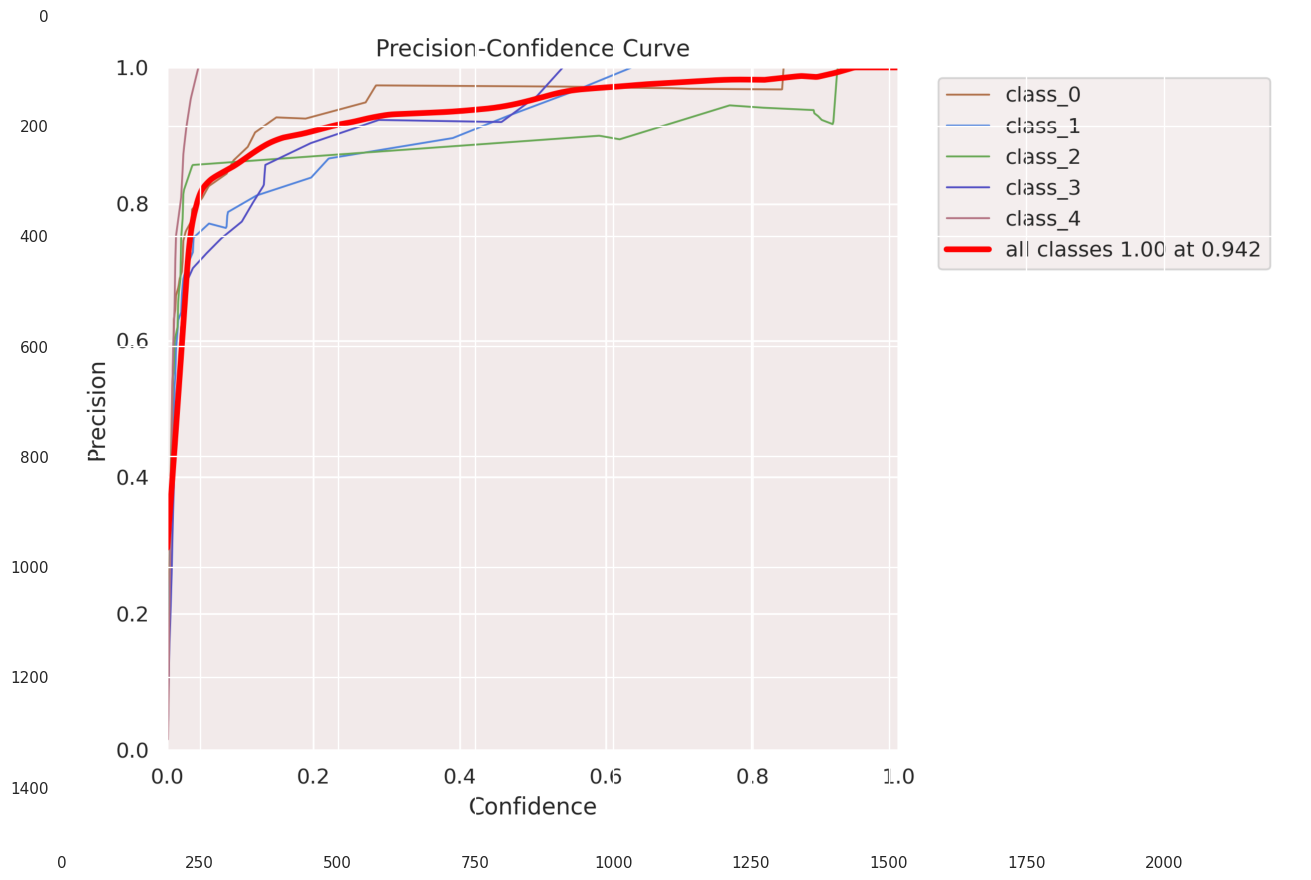

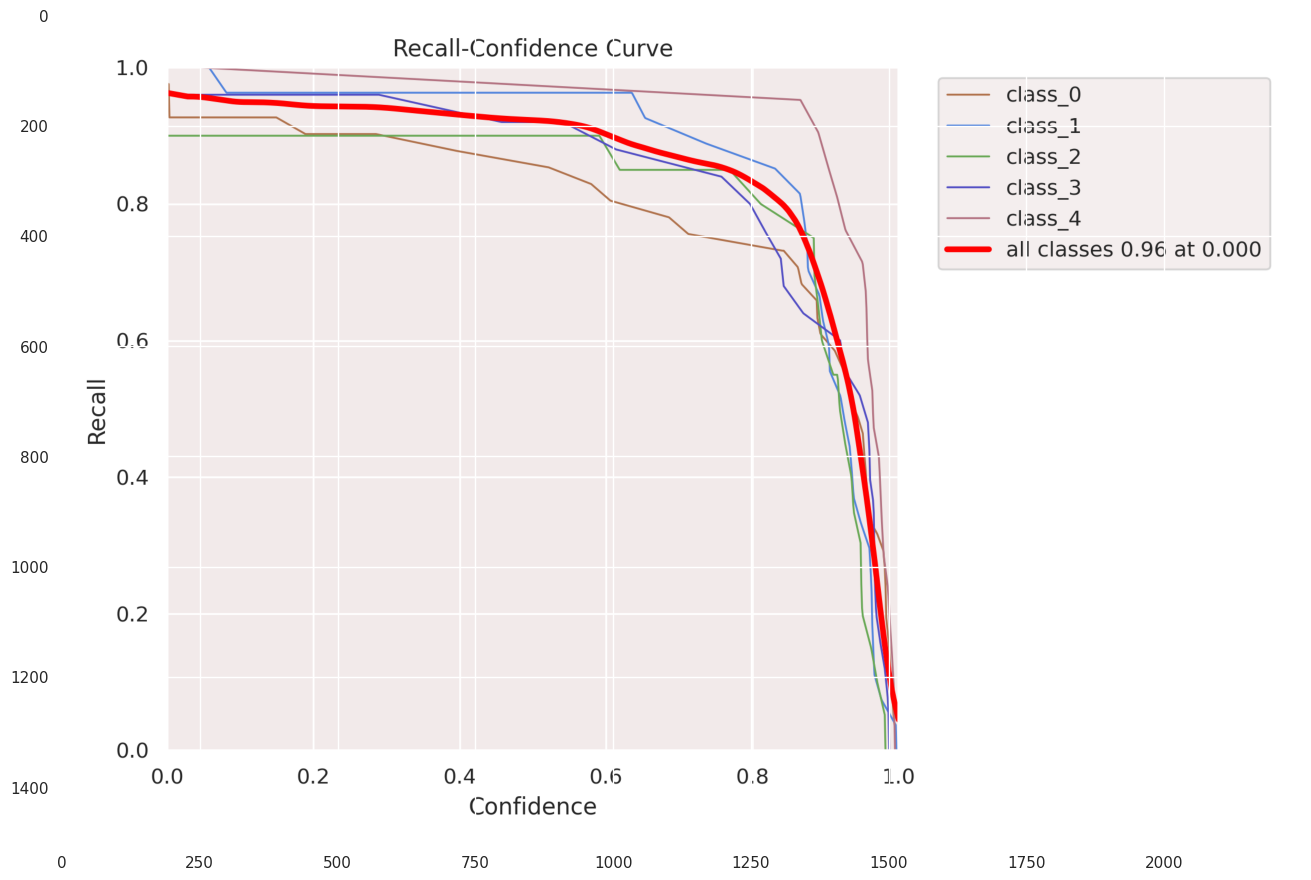

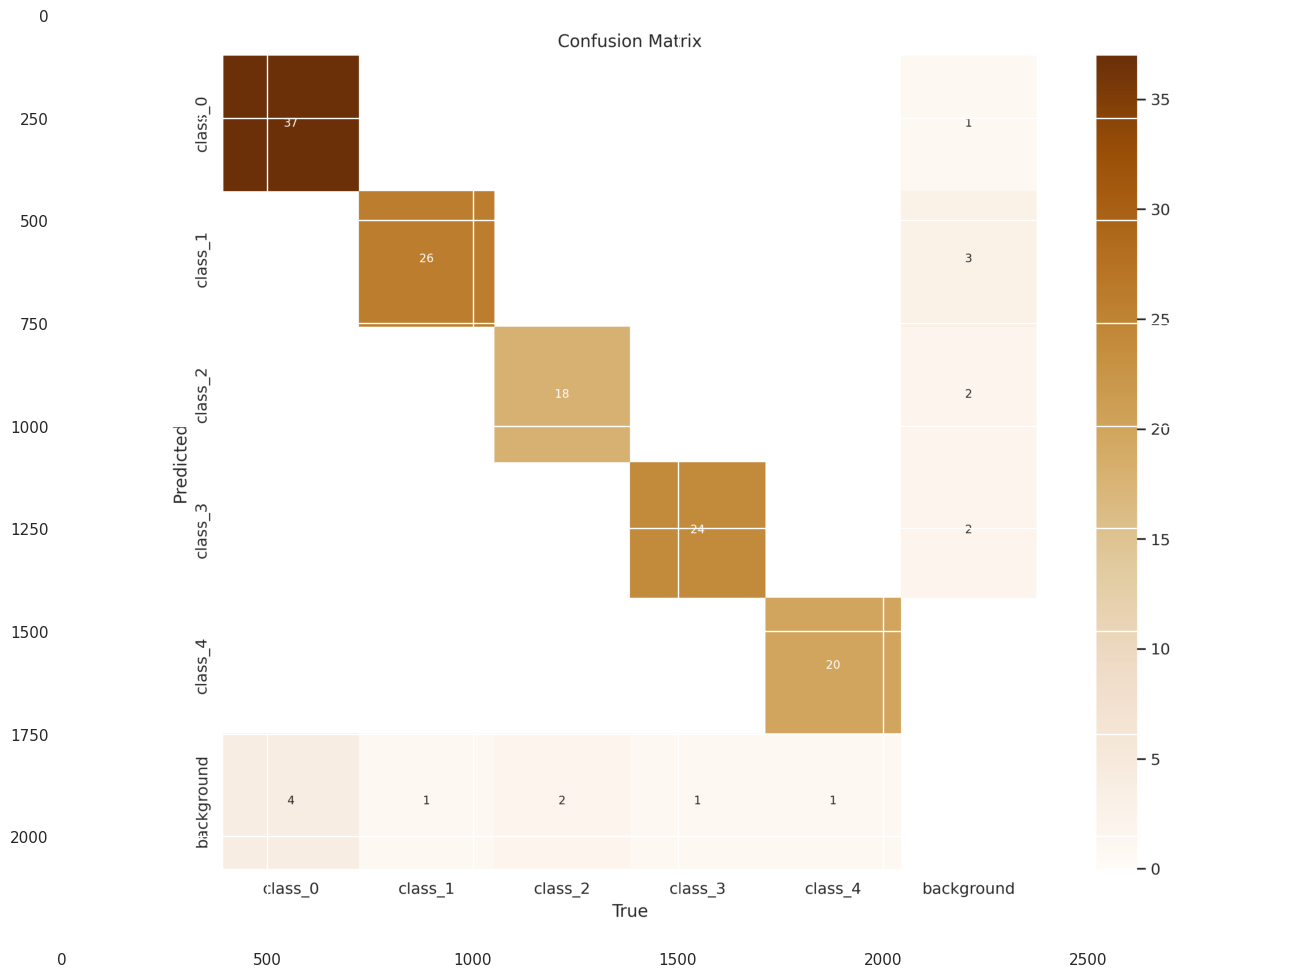

In [33]:
# Load the image
for i in list_of_metrics:
    image = cv2.imread(f'/content/runs/detect/train2/{i}')

    # Create a larger figure
    plt.figure(figsize=(16, 12))

    # Display the image
    plt.imshow(image)

    # Show the plot
    plt.show()


In [34]:
Result_Final_model = pd.read_csv('/content/runs/detect/train2/results.csv')
Result_Final_model.tail(40)

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,0.79801,3.79870,1.01850,0.00390,0.76127,0.25670,0.21963,0.69631,3.68950,0.80530,0.000178,0.000178,0.000178
1,2,0.78587,1.92720,0.95508,0.00608,0.84558,0.56651,0.45620,0.73828,3.22930,0.82649,0.000342,0.000342,0.000342
2,3,0.75518,1.30810,0.94766,1.00000,0.14827,0.65507,0.54444,0.76980,3.06050,0.82925,0.000482,0.000482,0.000482
3,4,0.73475,1.15090,0.92030,1.00000,0.23934,0.79111,0.63928,0.81921,2.71460,0.86432,0.000597,0.000597,0.000597
4,5,0.75667,1.01300,0.93912,0.95940,0.67976,0.87480,0.71324,0.79767,1.78290,0.86236,0.000687,0.000687,0.000687
5,6,0.75844,1.12560,0.91441,0.89239,0.64503,0.77605,0.61044,0.89114,1.79810,0.89022,0.000744,0.000744,0.000744
6,7,0.70148,0.99358,0.89462,0.89985,0.87613,0.89027,0.69713,0.82523,1.02220,0.86065,0.000671,0.000671,0.000671
7,8,0.68309,0.90116,0.87802,0.93678,0.81436,0.90705,0.74062,0.75566,0.91086,0.86277,0.000598,0.000598,0.000598
8,9,0.65091,0.84291,0.87286,0.91473,0.86743,0.91723,0.77185,0.71119,0.83517,0.84057,0.000524,0.000524,0.000524
9,10,0.57516,0.78892,0.85782,0.92350,0.91369,0.93098,0.78726,0.66110,0.68934,0.83268,0.000451,0.000451,0.000451


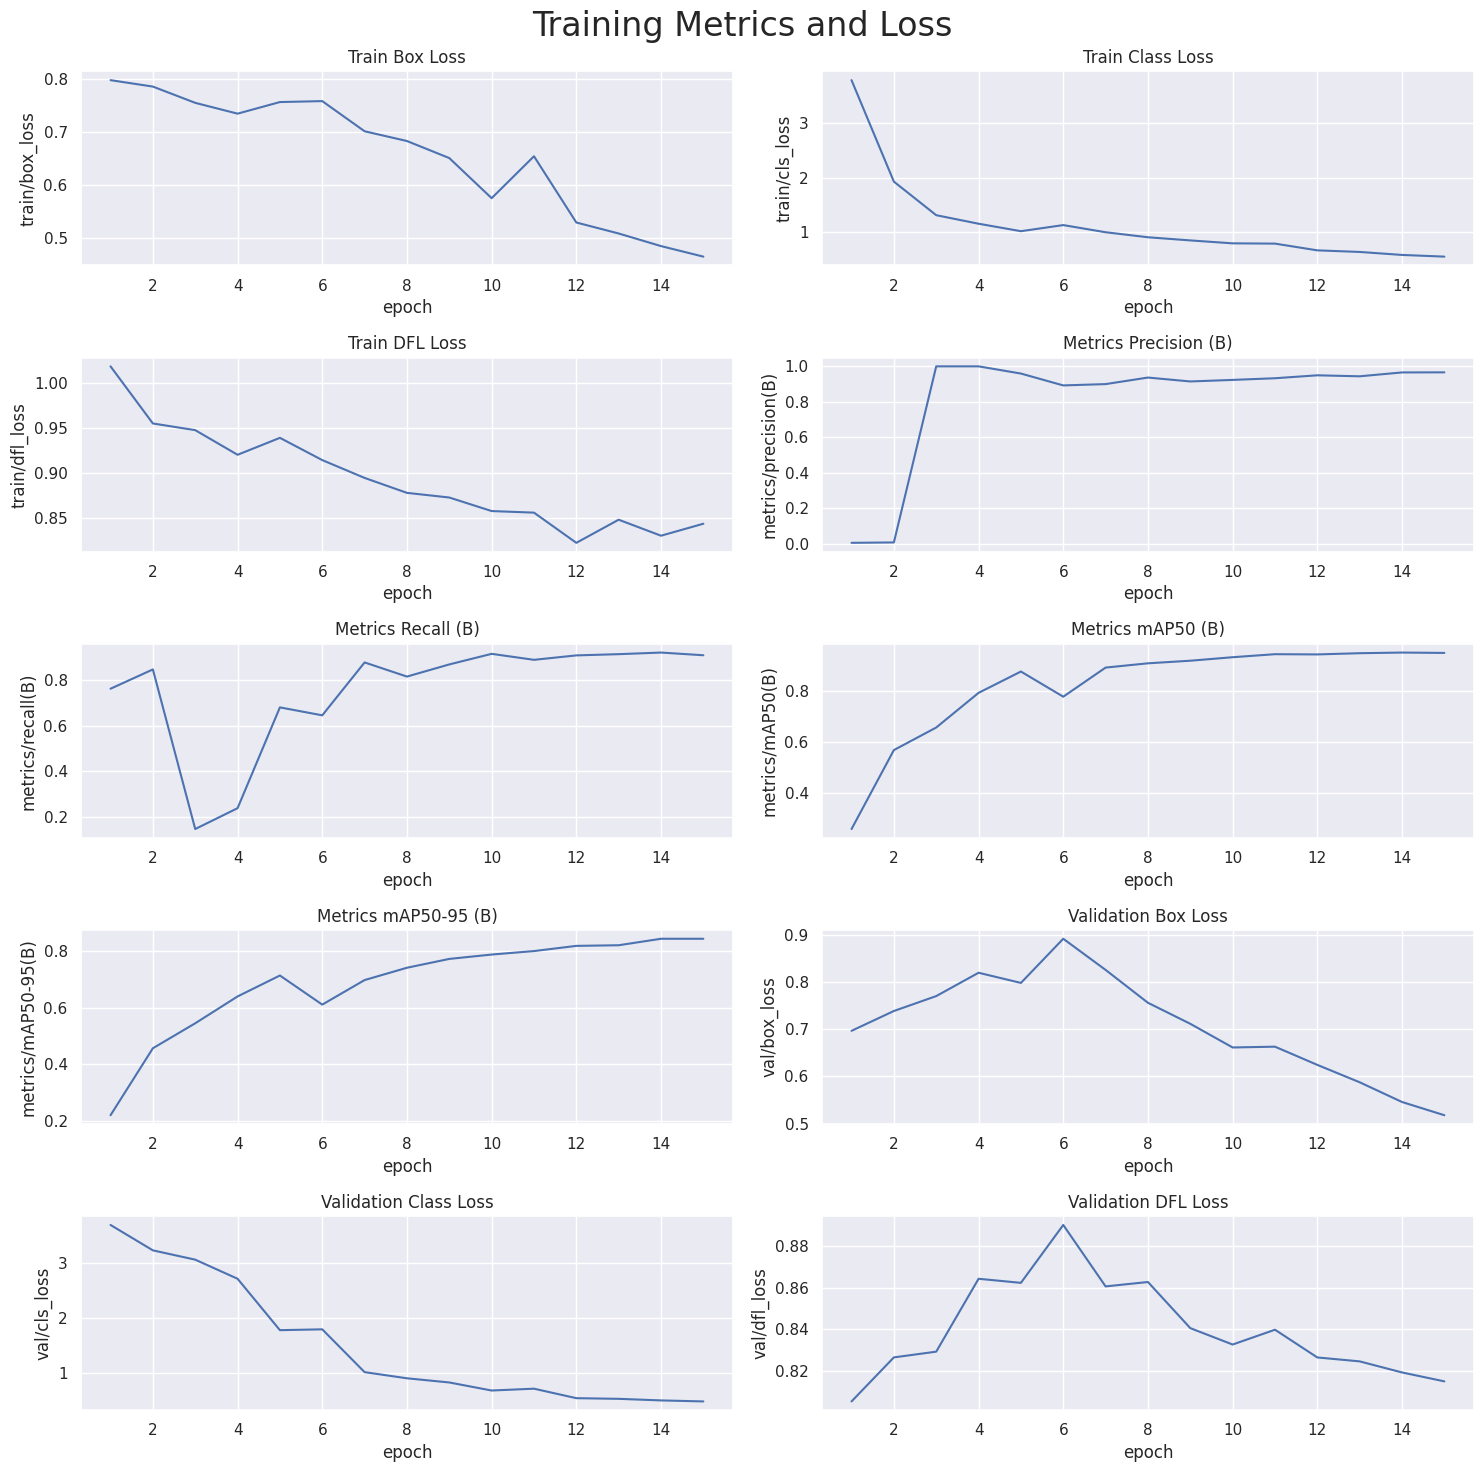

In [35]:
# Read the results.csv file as a pandas dataframe
df = Result_Final_model
Result_Final_model.columns = df.columns.str.strip()
# Create subplots
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# Plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# Set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')


plt.suptitle('Training Metrics and Loss', fontsize=24)
plt.subplots_adjust(top=0.8)
plt.tight_layout()
plt.show()

In [36]:
import os
import yaml
import matplotlib.pyplot as plt
import cv2

def get_class_images(labels_path, max_classes=5):
    class_ids = set()
    class_names = {}
    class_images = {}

    # Recorre todos los archivos .txt en la ruta labels_path
    for root, dirs, files in os.walk(labels_path):
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                image_file = file_path.replace('labels', 'images').replace('.txt', '.jpg')
                with open(file_path, 'r') as f:
                    for line in f.readlines():
                        parts = line.split()
                        class_id = int(parts[0])
                        class_name = parts[1] if len(parts) > 1 else f'class_{class_id}'
                        if class_id not in class_ids:
                            if len(class_ids) >= max_classes:
                                continue  # Salta esta clase si ya tenemos las máximas clases permitidas
                            class_ids.add(class_id)
                        if class_id not in class_names:
                            class_names[class_id] = class_name
                        if class_id not in class_images:
                            class_images[class_id] = []
                        class_images[class_id].append(image_file)

    return sorted(class_ids), class_names, class_images

# Rutas a las carpetas de etiquetas
val_labels_path = "/content/drive/MyDrive/dataset_vlc/labels/val"

# Obtener IDs de clases únicos y nombres de clases de las anotaciones
val_class_ids, val_class_names, val_class_images = get_class_images(val_labels_path)

# Combinar y ordenar los IDs de clases únicos
all_class_ids = sorted(set(val_class_ids))

# Combinar los diccionarios de nombres de clases e imágenes
all_class_names = {**val_class_names}
all_class_images = {**val_class_images}

# Imprimir el diccionario de mapeo de clases
print("Diccionario de Mapeo de Clases:")
for class_id in all_class_ids:
    print(f"ID de Clase: {class_id} -> Nombre: {all_class_names[class_id]}")

# Crear una lista ordenada de nombres de clases según los IDs de clase ordenados
class_names = [all_class_names[class_id] for class_id in all_class_ids]

# Crear el diccionario para el archivo data.yaml
data = {
    'val': "/content/drive/MyDrive/dataset_vlc/images/val",
    'nc': len(class_names),
    'names': class_names
}

# Guardar el archivo data.yaml
data_yaml_path = "/content/drive/MyDrive/dataset_vlc/data_test_5_classes.yaml"
with open(data_yaml_path, 'w') as yaml_file:
    yaml.dump(data, yaml_file, default_flow_style=False)

print(f"\nArchivo data.yaml creado con éxito en: {data_yaml_path}")


Diccionario de Mapeo de Clases:
ID de Clase: 0 -> Nombre: 0.891745
ID de Clase: 1 -> Nombre: 0.502825
ID de Clase: 2 -> Nombre: 0.489623
ID de Clase: 3 -> Nombre: 0.439505
ID de Clase: 4 -> Nombre: 0.652359

Archivo data.yaml creado con éxito en: /content/drive/MyDrive/dataset_vlc/data_test_5_classes.yaml


In [ ]:
# import os
# import yaml
# import matplotlib.pyplot as plt
# import cv2

# def get_class_images(labels_path):
#     class_ids = set()
#     class_names = {}
#     class_images = {}

#     # Recorre todos los archivos .txt en la ruta labels_path
#     for root, dirs, files in os.walk(labels_path):
#         for file in files:
#             if file.endswith(".txt"):
#                 file_path = os.path.join(root, file)
#                 image_file = file_path.replace('labels', 'images').replace('.txt', '.jpg')
#                 with open(file_path, 'r') as f:
#                     for line in f.readlines():
#                         parts = line.split()
#                         class_id = int(parts[0])
#                         class_name = parts[1] if len(parts) > 1 else f'class_{class_id}'
#                         class_ids.add(class_id)
#                         if class_id not in class_names:
#                             class_names[class_id] = class_name
#                         if class_id not in class_images:
#                             class_images[class_id] = []
#                         class_images[class_id].append(image_file)

#     return sorted(class_ids), class_names, class_images

# # Rutas a las carpetas de etiquetas
# val_labels_path = "/content/drive/MyDrive/dataset_vlc/labels/val"

# # Obtener IDs de clases únicos y nombres de clases de las anotaciones
# val_class_ids, val_class_names, val_class_images = get_class_images(val_labels_path)

# # Combinar y ordenar los IDs de clases únicos
# all_class_ids = sorted(set(val_class_ids))

# # Combinar los diccionarios de nombres de clases e imágenes
# all_class_names = {**val_class_names}
# all_class_images = {**val_class_images}

# # Imprimir el diccionario de mapeo de clases
# print("Diccionario de Mapeo de Clases:")
# for class_id in all_class_ids:
#     print(f"ID de Clase: {class_id} -> Nombre: {all_class_names[class_id]}")

# # Crear una lista ordenada de nombres de clases según los IDs de clase ordenados
# class_names = [all_class_names[class_id] for class_id in all_class_ids]

# # Crear el diccionario para el archivo data.yaml
# data = {
#     'val': "/content/drive/MyDrive/dataset_vlc/images/val",
#     'nc': len(class_names),
#     'names': class_names
# }

# # Guardar el archivo data.yaml
# data_yaml_path = "/content/drive/MyDrive/dataset_vlc/data_test_v1.yaml"
# with open(data_yaml_path, 'w') as yaml_file:
#     yaml.dump(data, yaml_file, default_flow_style=False)

# print(f"\nArchivo data.yaml creado con éxito en: {data_yaml_path}")

In [37]:
# Loading the best performing model
Valid_model = YOLO('/content/runs/detect/train2/weights/best.pt')

# Evaluating the model on the testset
metrics = Valid_model.val(split='val')

Ultralytics YOLOv8.2.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/dataset_vlc/labels/val.cache... 219 images, 99 backgrounds, 0 corrupt: 100%|██████████| 219/219 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.12it/s]


                   all        219        134      0.967      0.918      0.949      0.842
               class_0         32         41      0.972      0.842      0.933      0.823
               class_1         27         27       0.97      0.963      0.989      0.913
               class_2         20         20      0.896        0.9      0.877      0.792
               class_3         21         25          1      0.916      0.953      0.817
               class_4         20         21          1      0.971      0.995      0.863
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/val3


In [38]:
# Loading the best performing model
Valid_model = YOLO('/content/runs/detect/train2/weights/best.pt')

# Evaluating the model on the testset
metrics = Valid_model.val(split='val')

# final results
print("precision(B): ", metrics.results_dict["metrics/precision(B)"])
print("metrics/recall(B): ", metrics.results_dict["metrics/recall(B)"])
print("metrics/mAP50(B): ", metrics.results_dict["metrics/mAP50(B)"])
print("metrics/mAP50-95(B): ", metrics.results_dict["metrics/mAP50-95(B)"])
model_export = Valid_model.export(format='onnx')  # export the model to ONNX format

Ultralytics YOLOv8.2.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/dataset_vlc/labels/val.cache... 219 images, 99 backgrounds, 0 corrupt: 100%|██████████| 219/219 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:16<00:00,  1.18s/it]


                   all        219        134      0.967      0.918      0.949      0.842
               class_0         32         41      0.972      0.842      0.933      0.823
               class_1         27         27       0.97      0.963      0.989      0.913
               class_2         20         20      0.896        0.9      0.877      0.792
               class_3         21         25          1      0.916      0.953      0.817
               class_4         20         21          1      0.971      0.995      0.863
Speed: 0.0ms preprocess, 2.3ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/val4
precision(B):  0.9674723899447635
metrics/recall(B):  0.9181663395511995
metrics/mAP50(B):  0.9494909136675614
metrics/mAP50-95(B):  0.8418469741758272
Ultralytics YOLOv8.2.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from '/content/runs/detect/train2/weights/best.pt' with input shape (1, 3, 224, 224) BCHW and o


image 1/1 /content/drive/MyDrive/dataset_vlc/images/train/1004.jpg: 128x224 1 class_2, 8.9ms
Speed: 1.0ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 128, 224)


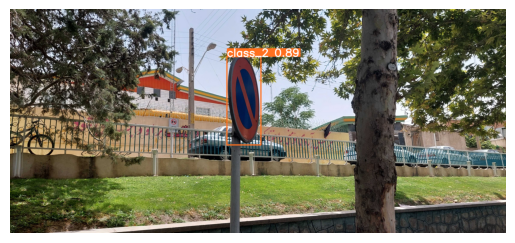


image 1/1 /content/drive/MyDrive/dataset_vlc/images/train/1609.jpg: 128x224 1 class_3, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 128, 224)


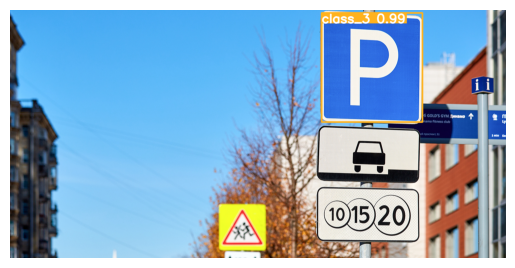

In [39]:
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO

# Cargar el modelo YOLO
model = YOLO('/content/runs/detect/train2/weights/best.pt')  # Ajusta la ruta según tu modelo YOLO

# Ruta de la imagen en la que deseas hacer la predicción
image_path = '/content/drive/MyDrive/dataset_vlc/images/train/1004.jpg'

# Realizar la predicción
results = model.predict(source=image_path)

# Obtener la imagen original
image = cv2.imread(image_path)  # Lee la imagen con OpenCV para mantener los colores correctos

# Plotear la imagen con matplotlib
plot = results[0].plot()
plt.imshow(cv2.cvtColor(plot, cv2.COLOR_BGR2RGB))  # Convierte de BGR (formato de OpenCV) a RGB (formato de matplotlib)
plt.axis('off')  # Deshabilita los ejes
plt.show()


# Ruta de la imagen en la que deseas hacer la predicción
image_path = '/content/drive/MyDrive/dataset_vlc/images/train/1609.jpg'

# Run inference on an image
results = model.predict(source=image_path)

# Plot inference results
plot = results[0].plot()
plt.imshow(cv2.cvtColor(plot, cv2.COLOR_BGR2RGB))  # Convierte de BGR (formato de OpenCV) a RGB (formato de matplotlib)
plt.axis('off')  # Deshabilita los ejes
plt.show()

In [40]:
import cv2
from matplotlib import pyplot as plt

# Replace with your actual YOLO model initialization
# Initialize YOLO model
model = YOLO('/content/runs/detect/train2/weights/best.pt')  # Adjust path according to your YOLO model

video_path = '/content/drive/MyDrive/Test_video_full.mp4'
cap = cv2.VideoCapture(video_path)

# Check if video file opened successfully
if not cap.isOpened():
    print("Error: No se pudo abrir el archivo de video.")
    exit()

# Define el codec y crea el objeto VideoWriter
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter('/content/drive/MyDrive/output_video_full.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width, frame_height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Perform object detection using YOLO model
    results = model.predict(frame)
    plot = results[0].plot()

    # Convert matplotlib RGB to OpenCV BGR
    plot = cv2.cvtColor(plot, cv2.COLOR_RGB2BGR)
    frame_rgb = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)

    # Guardar el frame procesado en el archivo de video de salida
    out.write(frame_rgb)

    # Mostrar el frame con la detección (opcional)
    # cv2.imshow('Frame', plot)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Liberar recursos
cap.release()
out.release()
cv2.destroyAllWindows()



0: 128x224 (no detections), 45.6ms
Speed: 0.9ms preprocess, 45.6ms inference, 6.2ms postprocess per image at shape (1, 3, 128, 224)

0: 128x224 (no detections), 56.3ms
Speed: 0.9ms preprocess, 56.3ms inference, 0.8ms postprocess per image at shape (1, 3, 128, 224)

0: 128x224 (no detections), 21.6ms
Speed: 1.4ms preprocess, 21.6ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 224)

0: 128x224 (no detections), 33.2ms
Speed: 3.7ms preprocess, 33.2ms inference, 0.9ms postprocess per image at shape (1, 3, 128, 224)

0: 128x224 (no detections), 16.6ms
Speed: 0.9ms preprocess, 16.6ms inference, 0.8ms postprocess per image at shape (1, 3, 128, 224)

0: 128x224 (no detections), 20.6ms
Speed: 0.8ms preprocess, 20.6ms inference, 0.8ms postprocess per image at shape (1, 3, 128, 224)

0: 128x224 (no detections), 23.9ms
Speed: 0.9ms preprocess, 23.9ms inference, 0.8ms postprocess per image at shape (1, 3, 128, 224)

0: 128x224 (no detections), 16.0ms
Speed: 0.8ms preprocess, 16.0ms i